## Portfolio: Olist e-commerce - Exploratory Data Analysis ##

**Problem Statement:**  
This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses. The dataset can be found here https://www.kaggle.com/olistbr/brazilian-ecommerce.

**Stakeholders:** 
* Olist platform managers 
* Olist sellers 
* Olist customers

## Part A. Import Cleaned Dataset ##

In [1]:
# Import all libraries #
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import csv
from sklearn.utils import shuffle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Authorization #
__author__ = "Taesun Yoo"
__email__ = "yoots1988@gmail.com"

In [2]:
# --- 1. Write Out List of Functions --- #
def load_file(file):
    '''load input CSVs as a dataframe'''
    return pd.read_csv(file, encoding='latin1')


def convert_dt_as_date(df, var_name, date_format):
    '''convert the variable as specified date format'''
    df[var_name] = pd.to_datetime(df[var_name], format=date_format)
    return df[var_name]


def convert_dt_as_custom(df, var_name, dt_type):
    '''convert datatype on selected variables'''
    df[var_name] = df[var_name].astype(dt_type)
    return df[var_name]


def convert_dt_to_cat(df):
    '''convert data type to category'''
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].astype('category')


def eda_encode_cat_var(df, col, num_var):
    '''encode the cat. variables by mean of a num. variable by each cat'''
    cat_dict={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat][num_var].mean()
    df[col] = df[col].map(cat_dict)


def clean_data(df):
    clean_df = df.drop_duplicates()
    # clean_df = clean_df[clean_df['profit_margin'] > 0]
    return clean_df


def join_data(df1, df2, join_type, key=None, 
              left_index=None, right_index=None):
    '''merge the dataframes by a key'''
    df_join = pd.merge(df1, df2, how=join_type, on=key,
                       left_index=False, right_index=False)
    return df_join


def feature_replacement(df):
    ''' replace missing values based on data types of columns '''
    for col in df.columns:
        if df[col].dtype.name == 'category':
            mode = df[col].mode().iloc[0]
            df[col] = df[col].fillna(mode)
        elif df[col].dtype.name == 'datetime64[ns]':
            pseudo_date = pd.Timestamp.max
            df[col] = df[col].fillna(pseudo_date)
        elif df[col].dtype.name == 'float64':
            mean = df[col].mean()
            df[col] = df[col].fillna(mean)
        else:
            df[col].dtype.name == 'int64'
            median = df[col].median()
            df[col] = df[col].fillna(median)
            

def eda_missing(df):
    '''compute missing % on each var'''
    df_missing = pd.DataFrame(df.isnull().sum(), columns=['count'])
    df_missing['pct'] = (df_missing['count']/len(df)) * 100
    return df_missing


def eda_stat_num(df):
    ''' perform eda for numerical features '''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'mean', 'max', 'std', '25%', '50%', '75%']]
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num


def eda_stat_cat(df):
    ''' perform eda for categorical features '''
    df_stat_cat = df.describe(include='category').T
    df_stat_cat = pd.DataFrame(df_stat_cat)
    return df_stat_cat


def eda_outliers(df):
    '''check outliers using the IQR method'''
    df['IQR'] = df['75%'] - df['25%']
    df['LB']  = df['25%'] - 1.5*df['IQR']
    df['UB']  = df['75%'] + 1.5*df['IQR']
    df = df.drop(['count','std','mean','25%','50%','75%','IQR'], axis=1)
    return df


def eda_agg_df_var(df, cat_var, kpi_dict):
    '''compute aggregated dataframe to calculate the KPIs'''
    df_agg = df.groupby(by=cat_var).agg(kpi_dict)
    return df_agg


def eda_grouped_df_var(df, cat_var):
    '''create a grouped dataframe by categorical variable'''
    df_grp = pd.DataFrame(df.groupby([cat_var])[cat_var].count())
    df_grp.columns = ['count']
    return df_grp


def plot_hist(df, var_1):
    '''plot a histogram'''
    plt.figure()
    print("skenewss is:", df[var_1].skew())
    df[var_1].hist(color='green')
    plt.title('Histogram of ' + var_1)
    plt.xlabel(var_1)
    plt.ylabel('transactions')
    plt.show()


def plot_bar_chart(df, var_name_1):
    '''plot a bar chart'''
    plt.figure(figsize=(12,12))
    var_count_1 = df[var_name_1].value_counts().sort_values(ascending=False)
    sns.barplot(var_count_1.index,  var_count_1.values, order=var_count_1.index, alpha=0.9)
    plt.title('Frequency chart of ' + var_name_1)
    plt.ylabel('transactions')
    plt.xlabel(var_name_1)
    plt.xticks(rotation=270)
    plt.show()
    
    
def plot_freq_chart(x,y,df,order):
    '''plot a frequency chart'''
    plt.figure(figsize=(8,8))
    sns.countplot(x=x, hue=y, data=df, order=order)
    plt.title('Bar chart: ' + x + ' of customer group labels', fontsize=20)
    plt.xticks(rotation=270, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel('transactions', fontsize=12)
    plt.legend(loc='upper right', fontsize=20)
    plt.show()


def plot_pie_chart(df_1, var_name_1,
                   df_2, var_name_2):
    '''plot a pie chart of specified variables'''
    plt.figure(figsize=(15,15))
    # Sub-plot 1:
    plt.subplot(1,2,1)
    plt.pie(df_1, autopct='%.0f%%', wedgeprops={'edgecolor':'white'},
            textprops={'fontsize':15})
    plt.title('Pie Chart of '+ var_name_1)
    plt.legend(labels = df_1.index, loc='upper right')
    # Sub-plot 2:
    plt.subplot(1,2,2)
    plt.pie(df_2, autopct='%.0f%%', wedgeprops={'edgecolor':'white'},
            textprops={'fontsize':15})
    plt.title('Pie Chart of '+ var_name_2)
    plt.legend(labels = df_2.index, loc='upper right')
    plt.show()
    

def plot_box(df, num_var_1, cat_var_1,
             num_var_2, cat_var_2, 
             num_var_3, cat_var_3, hue=None):
    '''plot a box-whisker of specified variables'''
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    # Sub-plot 1:
    plt.subplot(1,3,1)
    df.sort_values(by=[num_var_1], inplace=True)
    sns.set(style='whitegrid')
    sns.boxplot(cat_var_1, num_var_1, hue, df)
    plt.title('Box plot of ' + num_var_1 + ' by ' + cat_var_1)
    plt.xticks(rotation=270, fontsize=10)
    # Sub-plot 2:
    plt.subplot(1,3,2)
    df.sort_values(by=[num_var_2], inplace=True)
    sns.set(style='whitegrid')
    sns.boxplot(cat_var_2, num_var_2, hue, df)
    plt.title('Box plot of ' + num_var_2 + ' by ' + cat_var_2)
    plt.xticks(rotation=270, fontsize=10)
    # Sub-plot 3:
    plt.subplot(1,3,3)
    df.sort_values(by=[num_var_3], inplace=True)
    sns.set(style='whitegrid')
    sns.boxplot(cat_var_3, num_var_3, hue, df)
    plt.title('Box plot of ' + num_var_3 + ' by ' + cat_var_3)
    plt.xticks(rotation=270, fontsize=10)    

    
def plot_crosstab(df, cat_var_1, cat_var_2):
    '''plot a crosstab of two categorical variables'''
    table = pd.crosstab(df[cat_var_1], df[cat_var_2])
    return table


def plot_corr_matrix(df, list_vars):
    ''' plot a correlation matrix '''
    corr = df[list_vars].corr()
    # Create a mask
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(corr)] = True
    plt.figure(figsize=(12,12))
    sns.heatmap(corr, mask=mask, square=True, linewidths = .5,
                cmap=sns.diverging_palette(220,10,as_cmap=True),
                vmin = -1, vmax = 1, fmt=".2f",
                annot=True, annot_kws={'size':11})
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


def plot_scatter(df, var_1, var_2, color, factor=None):
    '''Scatter plot of two continuous numeric features'''
    plt.figure(figsize=(8,8))
    plt.scatter(df[var_1]*factor, df[var_2], color=color)
    plt.title('Relationship between '+ var_1 + ' and ' + var_2)
    plt.xlabel(var_1)
    plt.ylabel(var_2)
    plt.show()

    
def compute_pearson_r(df, var_x, var_y):
    '''compute Pearson r correlation'''
    corr_mat = np.corrcoef(df[var_x],df[var_y])
    return corr_mat[0, 1]


def plot_linear_reg(df, var_x, var_y, 
                    pearson_r, color, label):
    '''plot a pair of linear regressions'''
    plt.figure(figsize=(10,10))
    plt.plot(df[var_x], df[var_y], 'r--', label='pearson_r =%.2f' % pearson_r,
             marker='.', linestyle='none', color=color)
    plt.margins(0.02)
    plt.legend(loc='upper left')
    plt.xlabel(var_x)
    plt.ylabel(var_y)
    plt.title(var_x + ' vs. ' + var_y + ' by ' + label)
    # Fit linear regression:
    a,b = np.polyfit(df[var_x], df[var_y], 1)
    x = np.array([min(df[var_x]), max(df[var_x])])
    y = a*x + b
    plt.plot(x,y)


def write_as_csv(df, filename, filepath):
    ''' save the dataframe as .csv file in specific filepath '''
    df.to_csv(os.path.join(filepath, filename), index=False, index_label=None)

In [3]:
# --- 2. Load the data --- #
# define input CSVs:
if __name__ == '__main__':
    customers = 'olist_customers.csv'
    orders = 'olist_orders.csv'
    order_items = 'olist_order_items.csv'
    order_payment = 'olist_order_payments.csv'
    products = 'olist_products.csv'
    prod_name_translator = 'olist_products_name_translator.csv'
    sellers = 'olist_sellers.csv'
    # order_reviews = 'olist_order_reviews.csv'
    # geolocation = 'olist_geolocation.csv'
    
# Load data
customers = load_file(customers)
orders = load_file(orders)
order_items = load_file(order_items)
order_payment = load_file(order_payment)
products = load_file(products)
prod_name_translator = load_file(prod_name_translator)
sellers = load_file(sellers)

# rename the columns
orders.rename(columns={'order_purchase_timestamp':'order_purchase_date',
                       'order_approved_at':'order_approved_date'}, inplace=True)    

products.rename(columns={'product_category_name':'prod_cat_name', 
                         'product_name_lenght':'prod_name_length', 
                         'product_description_lenght':'prod_desc_length',
                         'product_photos_qty':'prod_photo_qty', 
                         'product_weight_g':'prod_weight_g',
                         'product_length_cm':'prod_length_cm', 
                         'product_height_cm':'prod_height_cm',
                         'product_width_cm':'prod_width_cm'}, inplace=True)    

prod_name_translator.rename(columns={'ï»¿product_category_name':'prod_cat_name',
                                     'product_category_name_english':'prod_cat_name_eng'},inplace=True)

In [4]:
# --- 3. ETL data transforms ---
# Join operations between data tables #
# left joins order_items to orders on order_id
df_join_1 = join_data(order_items, orders, 'left', 'order_id')

# left joins df_join_1 to products on product_id
df_join_2 = join_data(df_join_1, products, 'left', 'product_id')

# left joins df_join_2 to sellers on seller_id
df_join_3 = join_data(df_join_2, sellers, 'left', 'seller_id')

# left joins df_join_3 to prod_name_translator on prod_cat_name
df_join_4 = join_data(df_join_3, prod_name_translator, 'left', 'prod_cat_name')

# left joins df_join_4 to customers on customer_id
df_join_5 = join_data(df_join_4, customers, 'left', 'customer_id')

# left joins df_join_5 to order payment on order_id
olist_data = join_data(df_join_5, order_payment, 'left', 'order_id')

# delete the set of dataframes
del(customers, orders, order_items, order_payment, products, prod_name_translator, sellers)
del(df_join_1, df_join_2, df_join_3, df_join_4, df_join_5)

# check the data types on final dataframe
olist_data.dtypes

# check the column names
olist_data.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'customer_id',
       'order_status', 'order_purchase_date', 'order_approved_date',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'prod_cat_name', 'prod_name_length',
       'prod_desc_length', 'prod_photo_qty', 'prod_weight_g', 'prod_length_cm',
       'prod_height_cm', 'prod_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'prod_cat_name_eng',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [5]:
# --- 4. ETL: data cleaning ---
# check any duplicates
olist_data.duplicated().sum()    

# clean the data -  remove duplicates
olist_data_clean = shuffle(clean_data(olist_data)).reset_index(drop=True)

# subset duplicated rows:
mask_dups = olist_data_clean.duplicated()
df_dups = olist_data_clean[mask_dups]
del(df_dups, olist_data)

# format date into datetime
date_format = '%Y-%m-%d'
convert_dt_as_date(olist_data_clean, 'order_purchase_date', date_format)
convert_dt_as_date(olist_data_clean, 'order_delivered_customer_date', date_format)

# convert data type: object to category
convert_dt_to_cat(olist_data_clean)

df_eda = olist_data_clean.copy()
del(olist_data_clean)

In [6]:
# define variables: date(s)
vars_dates = ['shipping_limit_date', 'order_purchase_date', 'order_approved_date',
              'order_estimated_delivery_date', 'order_delivered_carrier_date', 
              'order_delivered_customer_date']

# define variables: categorical
vars_cat = df_eda.nunique()[df_eda.nunique() < 28938].keys().tolist()

# remove/add variables to vars_cat
unwanted_items = ['price', 'freight_value', 'order_estimated_delivery_date']
wanted_items = ['order_id', 'customer_id', 'customer_unique_id', 'product_id']

vars_cat = [col for col in vars_cat if col not in unwanted_items]
vars_cat.extend(wanted_items)

# define variables: numerical
vars_num = [col for col in df_eda.columns if col not in vars_dates + vars_cat]

## Part B. Exploratory Data Analysis ##

### Dataset Name: Training Set ###
Data exploration is conducted on a cleaned training set. The main goal of this phase is to explore any interesting relationships among features and identify which features are good predictors on poverty rate predictions.

Following set of questions are asked:
1. Can I count something interesting?
2. Can I find some trends (increase or decrease and any anomalies)?
3. Can I plot a bar chart or a histogram?
4. Can I make a scatter plot?

These set of guiding questions will help us to explore any insights and tell a compelling story about the US poverty dataset.

In [7]:
# compute top 10 rows:
df_eda.head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_date,...,seller_state,prod_cat_name_eng,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,9f792c846e897702e89fb06829be1b0b,1,68bf2e76db1d8e846042e54da87399ca,1a3df491d1c4f1589fc2b934ada68bf2,2017-09-21 23:55:10,85.90,47.13,827cbe2af76bd50839030b7576d704e8,delivered,2017-09-13 23:41:20,...,SC,bed_bath_table,9f5e91d56f3c3c192a0ee7fa88de7113,52020,recife,PE,1.0,credit_card,10.0,133.03
1,317c2c773295f70b67e5511ccd55f81c,1,53b36df67ebb7c41585e8d54d6772e08,4869f7a5dfa277a7dca6462dcf3b52b2,2017-08-07 00:43:11,159.90,12.62,1a87ac7d56c7f9d337a271a7c157184c,delivered,2017-08-01 00:03:15,...,SP,watches_gifts,04effeb71dfa28a5096368addc3994be,5730,sao paulo,SP,1.0,credit_card,3.0,172.52
2,6651f029ead38cdcfbbe495f5cce1e4a,1,5a7373ba4c9b3e13513ded06cd1986c4,e9779976487b77c6d4ac45f75ec7afe9,2018-08-01 02:10:35,33.49,18.33,12638fa4003c4213b65e5ebdb9560a6d,delivered,2018-07-25 14:43:57,...,SP,sports_leisure,341cea8bb2dcd4d5d57719a1768aa5f7,90810,porto alegre,RS,1.0,boleto,1.0,51.82
3,c5e44ccca834721d269f1227236ae8be,1,4697e1b622324d38a8989bff2bdc1c84,1da3aeb70d7989d1e6d9b0e887f97c23,2018-07-17 11:15:22,19.99,19.05,c9d717c837919bc6ee17ffab4ccbb3e8,delivered,2018-07-13 11:05:00,...,SP,stationery,4b9e2aca5187a85bf25773aa80c15d52,60192,fortaleza,CE,1.0,credit_card,1.0,39.04
4,c75eebf08446545f765d7cfc1ab89342,1,3c5559ffe829dd89665484c98f0c4e18,6b90f847357d8981edd79a1eb1bf0acb,2018-07-05 11:30:19,69.90,9.24,f971a3a1f0bff189598bbfb8b62466aa,delivered,2018-07-01 11:15:50,...,SP,consoles_games,5899c283996ee4c68070c035065316ac,3012,sao paulo,SP,1.0,credit_card,1.0,79.14
5,7bba749eac1bb22b7afe577fa772f2c5,1,b3d4d6113e42b86ceb66060424125828,20d83f3ef0e6925fd74bfd59170babf7,2018-05-18 15:59:35,49.90,7.39,f4aafd406bb5c1eef5305b37167fb6be,delivered,2018-05-15 23:56:01,...,SP,fashion_bags_accessories,1b30331141de478842873a312150e343,11070,santos,SP,1.0,boleto,1.0,57.29
6,b0b54e4c452d66681d67e588398ecf7c,1,3e71aff24a7ddd21185c3d41ecd9b335,c8b0e2b0a7095e5d8219575d5e7e1181,2018-01-15 13:31:57,135.99,23.27,efa32e2c1c2454217b3c5c9b09f648cc,delivered,2018-01-09 13:21:39,...,SP,auto,3d93772915efa454a89bf52047b0b285,32050,contagem,MG,1.0,credit_card,2.0,59.26
7,3b550d526029241325a94aa30a60cff0,1,01e66dc5bf4d5a186d856506a4f0fea2,a5dd1946fb63ada8bcaa0c9cd8f11e22,2017-09-15 14:25:18,24.41,12.60,ba94d08242444ec7bb6504275a6d7c4d,delivered,2017-09-08 14:15:39,...,PE,sports_leisure,47a164a775858920248b4269be24a00a,50741,recife,PE,1.0,credit_card,3.0,37.01
8,1d168d043fa86715964cec5b45433fd4,1,4eea8502d7c2de8da6eea6bc6243b50c,8e8a7ce9f2f970dc00e2acf6f6e199f6,2018-06-22 16:25:29,145.00,19.12,56592057a862a75cc27d9be9b90a2ef5,delivered,2018-06-19 15:36:19,...,RJ,computers_accessories,cb102d80a65deaf0c899457c30371166,37993,capetinga,MG,1.0,credit_card,1.0,164.12
9,c2366de030bbb08e26d86e7489ce65c9,1,66b5f91356d928ae807ab4ee547f5e3e,f45122a9ab94eb4f3f8953578bc0c560,2017-10-18 04:49:37,42.99,15.10,edafb59d9c6c921ea0a8f06d3b179c8b,delivered,2017-10-10 13:28:04,...,SP,pet_shop,8beac40d60f202a69373cf2060419df4,35624,cedro do abaete,MG,1.0,boleto,1.0,58.09


In [8]:
# create a missing % dataframe: before
df_missing_pre = eda_missing(df_eda)
df_missing_pre

,count,pct
order_id,0,0.000000
order_item_id,0,0.000000
product_id,0,0.000000
seller_id,0,0.000000
shipping_limit_date,0,0.000000
price,0,0.000000
freight_value,0,0.000000
customer_id,0,0.000000
order_status,0,0.000000
order_purchase_date,0,0.000000


### Summary: Missing Values % ###
Above table shows that missing value % on each feature. app_underwriting_score misses about 3.7%.

In [9]:
# compute feature impuation by data types:
feature_replacement(df_eda)

In [10]:
# create a missing % dataframe: after
df_missing_post = eda_missing(df_eda)
df_missing_post

,count,pct
order_id,0,0.0
order_item_id,0,0.0
product_id,0,0.0
seller_id,0,0.0
shipping_limit_date,0,0.0
price,0,0.0
freight_value,0,0.0
customer_id,0,0.0
order_status,0,0.0
order_purchase_date,0,0.0


In [11]:
# ---3 perform summary statistics ---
# numerical features:
df_stat_num = eda_stat_num(df_eda[vars_num])
df_stat_num

,count,min,mean,max,std,25%,50%,75%
price,117604.0,0.85,120.822849,6735.00,184.477367,39.90,74.90,134.90
freight_value,117604.0,0.00,20.045551,409.68,15.861351,13.08,16.29,21.19
payment_value,117604.0,0.00,172.686752,13664.08,267.588877,60.87,108.22,189.26


### Summary Statistics: Numerical - Interpretation ###
* average price: of product(s) being sold at olist is around 120.8 Brazilian Real.
* average freight cost: for delivery to customers is around 20.1 Brazilian Real.
* average payment: of product(s) made by customers is around 172.7 Brazilian Real.

In [12]:
# categorical features:
df_stat_cat = eda_stat_cat(df_eda[vars_cat])
df_stat_cat

,count,unique,top,freq
seller_id,117604,3095,4a3ca9315b744ce9f8e9374361493884,2133
order_status,117604,7,delivered,115038
prod_cat_name,117604,73,cama_mesa_banho,13521
seller_city,117604,611,sao paulo,29157
seller_state,117604,23,SP,83854
prod_cat_name_eng,117604,71,bed_bath_table,13546
customer_city,117604,4110,sao paulo,18590
customer_state,117604,27,SP,49569
payment_type,117604,4,credit_card,86772
order_id,117604,98666,895ab968e7bb0d5659d16cd74cd1650c,63


### Summary Statistics: Categorical - Interpretation ###
* customer_state & seller_state: Based on transaction counts, top seller and customer city is from "Sao Paulo".
* prod_cat_name_eng: Surprisingly, the most selling product category is "Bed Bath Table"
* payment_type: Majoirty of customer's payments are received using a credit card.

In [13]:
# ---4 detect outliers ---
# create a dataframe for IQR:
df_outliers = eda_outliers(df_stat_num)
df_outliers

# check outliers:
# lower bounds (LBs)
df_eda[df_eda.freight_value < 0.915]

# upper bounds (UBs)
df_eda[df_eda.price > 277.4]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_date,...,seller_state,prod_cat_name_eng,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
22,4065c0062f606b943e2fef1d5454ce80,1,4cce3fa9fee9eb2361e0b9bd32516958,b839e41795b7f3ad94cc2014a52f6796,2018-03-07 10:35:40,799.00,25.08,df94163aaf41dc29d2051c88b9b6aa17,delivered,2018-03-01 10:18:57,...,SP,construction_tools_construction,99749d7ee01657cc0faeee7de4fea874,30310,belo horizonte,MG,1.0,credit_card,8.0,824.08
33,eefc2dca61d7ccab611eb2ef18eea94b,1,6fa1aab8448ff11026093b6169f05e54,ea67327e24487bdfac5fbfa37ea124df,2018-01-11 23:15:27,810.00,36.70,fef307b2eb12e7d5fb8aada30eae84f3,delivered,2018-01-07 23:08:30,...,SP,bed_bath_table,effa3ddcc2156bd137b576c00aeab4ff,4364,sao paulo,SP,1.0,credit_card,4.0,846.70
35,a4725f98a7344d345bb2fab1c3c39c54,1,5d9da5147623b060b44db5b01bf9e60a,a63bfbaa882c8f4542891b4e2246cc7f,2018-08-27 18:30:19,548.00,12.77,4a751dfba6004c315eaf88abf0ff249c,delivered,2018-08-23 18:19:17,...,RJ,health_beauty,7c675c73c913ef2bc355178d845e7209,21250,rio de janeiro,RJ,1.0,credit_card,10.0,560.77
72,29fc23bcd9e04ac6a5919350404eb36c,1,85e8e8aad6ad12d67c21300379760196,d6b664fa0667064c6d76394e7848d790,2018-03-11 22:08:45,1186.00,60.90,a2463c771cdc164e80078fd3d5e12ee0,delivered,2018-03-03 21:52:44,...,SP,garden_tools,0af81771d11ef9e0807a929428f9558d,85640,ampere,PR,1.0,credit_card,10.0,1246.90
94,c1b4f595f1ad8978da4537431bfe143f,1,926e66aed471a4345d1c8d70b60c1874,7bac63f6603d382cc8d0832eb6c100a8,2018-03-06 13:55:38,457.99,17.96,3c008d3dc45ecee73703f2846ef4cf33,delivered,2018-02-28 13:35:46,...,SP,sports_leisure,5b34e292d74ef57ad8c93f54fd640388,28470,santo antonio de padua,RJ,1.0,credit_card,5.0,475.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117552,aa7e3a2bfaf2aa8869ba241172c7ee1a,1,1b335291af6aa51e69afcce777570b9d,e62b2d6ac10570a035a30bafcf01d263,2018-02-02 20:53:22,319.90,14.58,5f5147e3ab165c9bd8caa7c7beb0231c,delivered,2018-01-28 20:46:15,...,SP,cool_stuff,b10016d13ffb39d79375b4646abb2aa8,17519,marilia,SP,1.0,credit_card,4.0,334.48
117557,2c559a6f1ac48c4f100f4775a1362ea1,1,738067b78d178e457fa0dc6db5d2cc58,30829ded4523ab9224b93bc49a62c95f,2018-01-17 18:11:25,523.19,18.41,5be5d703076bbbf577ade3fdddf51e20,delivered,2018-01-10 10:50:11,...,RS,computers_accessories,29bbf509bf085413d69208f1547f76e0,13871,sao joao da boa vista,SP,1.0,boleto,1.0,1083.20
117577,7738754cace77285b4b13ce8ea5979cb,1,e3baa4e51fbac37d48e70a8544895c1a,2e3be8a987a30d7544dbbda6861cc14e,2018-01-11 11:47:09,599.99,18.96,33ac5a0d983f8f8905499a9f926086f5,canceled,2018-01-03 11:37:39,...,MG,computers_accessories,8028fbabf6123c13297c82f4393a4724,1452,sao paulo,SP,1.0,credit_card,1.0,618.95
117579,fbae1b9dac9991f79b54655e26cbe64e,1,6767719f80aabbbf16ab2491899c32d9,c4d51195486dc781531876a7d00453d8,2018-06-13 20:51:12,839.99,23.76,13e1bfd20542fb44fba2f5c239eb02b3,delivered,2018-06-01 20:30:35,...,SP,telephony,e2e0e8c708af27b692d419af3bb3daa7,97542,alegrete,RS,1.0,credit_card,8.0,863.75


In [14]:
# ---5 aggregate dataframe and compute KPIs ---
# Define the dictionary for KPIs:
kpi_dict = {'customer_unique_id':'nunique', 'order_id':'count',
            'price':'mean', 'freight_value':'mean', 
            'payment_value':'mean',}

## aggregate by unique customers
#df_agg_customer = eda_agg_df_var(df_eda, 'customer_unique_id', kpi_dict)

# aggregate by customer's state
df_agg_state = eda_agg_df_var(df_eda, 'customer_state', kpi_dict)

# rename columns
df_agg_state = df_agg_state.rename(columns={'customer_unique_id':'unique_customers',
                                            'order_id':'order_counts',
                                           'price':'avg_price',
                                           'freight_value':'avg_freight',
                                           'payment_value':'avg_payment'})

# derive the KPIs: payment_per_customer, payment_per_order
df_agg_state['avg_payment_per_customer'] = df_agg_state.avg_payment/df_agg_state.unique_customers
df_agg_state['avg_payment_per_order'] = df_agg_state.avg_payment/df_agg_state.order_counts

# sort by payment_per_customer:
df_agg_state = df_agg_state.sort_values(by='avg_payment_per_customer', ascending=False)

# Print a summary KPI table:
df_agg_state

,unique_customers,order_counts,avg_price,avg_freight,avg_payment,avg_payment_per_customer,avg_payment_per_order
customer_state,,,,,,,
RR,45,52,150.565962,42.984423,239.657885,5.325731,4.608805
AP,67,84,162.551190,34.084405,257.651190,3.845540,3.067276
AC,77,95,179.573053,40.021684,262.998526,3.415565,2.768406
AM,142,171,133.388070,33.079181,203.235673,1.431237,1.188513
RO,235,286,164.209895,40.970175,230.370629,0.980301,0.805492
TO,272,339,165.934838,39.677286,213.218791,0.783893,0.628964
SE,338,397,153.538035,36.627935,222.764509,0.659067,0.561120
AL,399,458,181.463668,35.739410,242.979083,0.608970,0.530522
PB,516,639,193.624945,43.257778,283.230344,0.548896,0.443240


### Summary KPI Table: by Customer's State ###
On this table, we grouped data by "customer_state' and derived the KPIs like avg_payment_per_customer and avg_payment_per_order. There are different drivers behind why certain state's are more profitable (i.e., revenue) than other states.

For example, SP state is highly profitable due to the highest volume of unique customers and order counts. In fact, SP state is the worst perform with respect to the avg_payment_per_customer and avg_payment_per_order. Whereas RR state is the best performer with respect to the avg_payment_per_customer and avg_payment_per_order (i.e., due to the lowest volume of unique customers and order counts).

### Uni-variate: Histogram Plots ###

skenewss is: 14.09016867661366


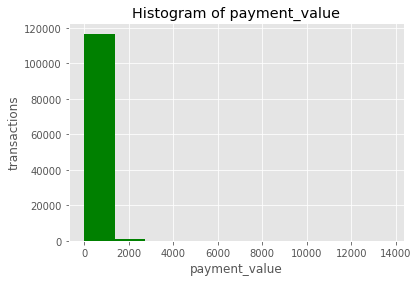

skenewss is: 5.542942721248473


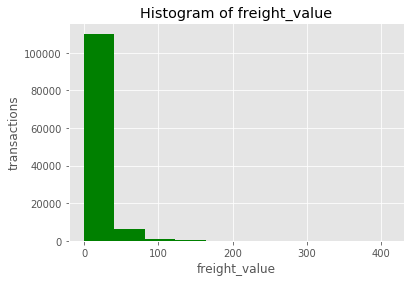

skenewss is: 7.885799084188858


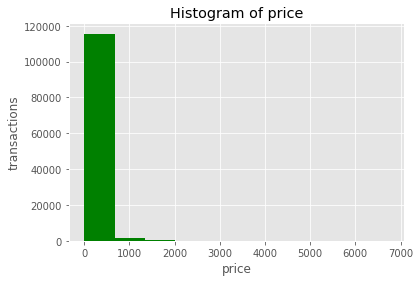

In [15]:
# ---6 visualize data: uni-variate ---
# plot a histogram:    
plot_hist(df_eda, 'payment_value')

plot_hist(df_eda, 'freight_value')

plot_hist(df_eda, 'price')

### Summary: Histograms ###
* Payment: positively skewed with majority of payments made under 170 Real.
* Freight: positively skewed with majority of freights cost under 20 Real.
* Price: positively skewed with majority of price made under 120 Real.

### Uni-variate: Bar Charts ###

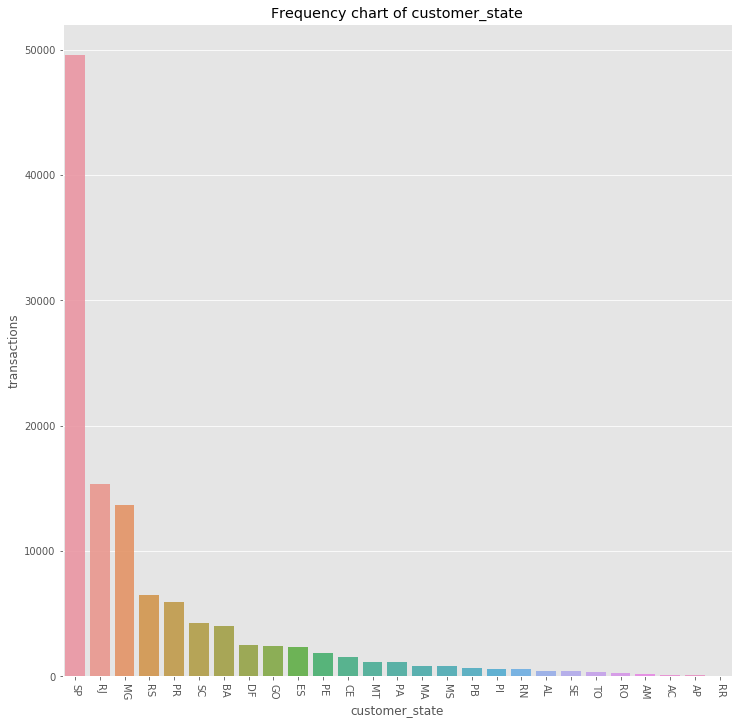

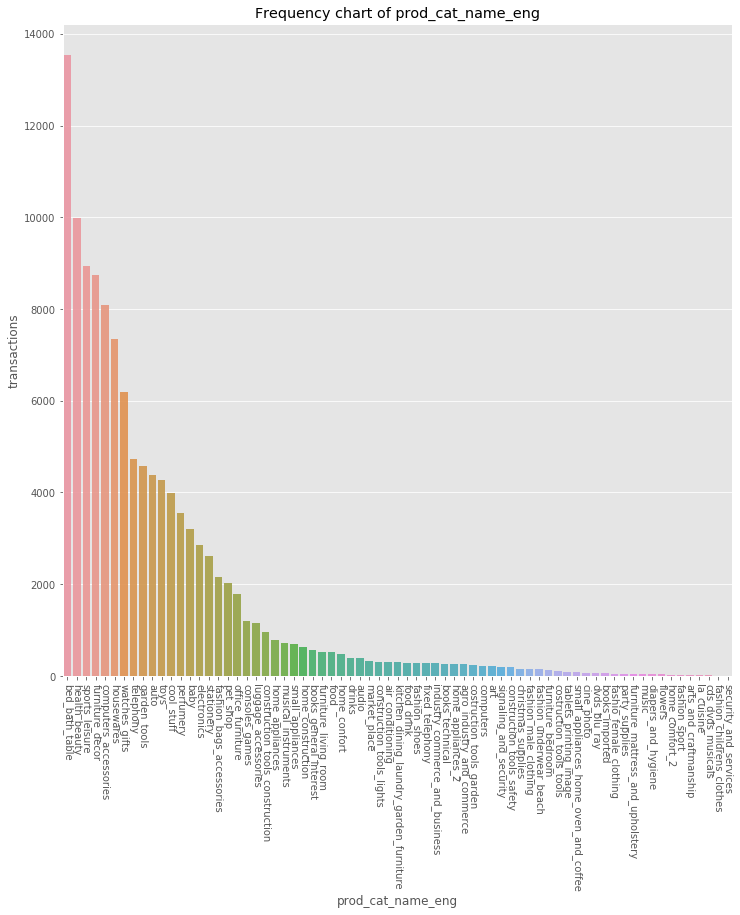

In [16]:
# plot a bar chart:
plot_bar_chart(df_eda, 'customer_state')
plot_bar_chart(df_eda, 'prod_cat_name_eng')

### Summary: Bar Charts ###
* Customer's State: majority of customers purchased from SP followed by RJ and MG states.
* Product Category: majority of customers purchased on "bed bath table" followed by "health beauty" and "sports leisure" products.

### Frequency Charts ###

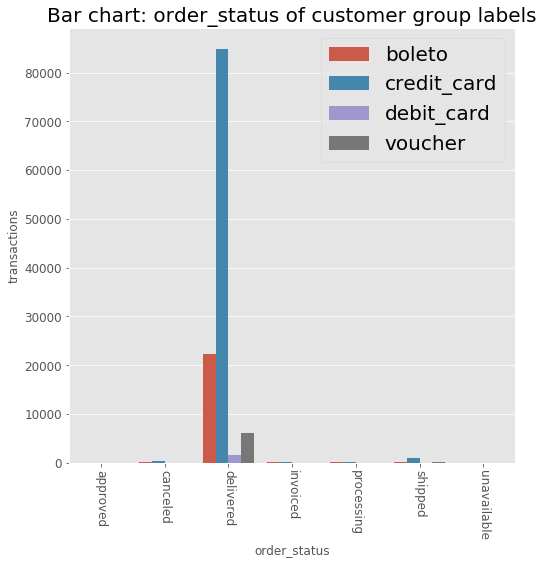

In [17]:
# plot a frequency chart:
plot_freq_chart('order_status', 'payment_type', df_eda, None)

### Summary: Frequency Chart 1 ###
* Order Status: majority of purchases are delivered, shipped and etc.
* Payment Type: majoirty of purchases are paid by "credit card" then follow by "boleto" and etc.

### Uni-variate: Pie Charts ###

C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


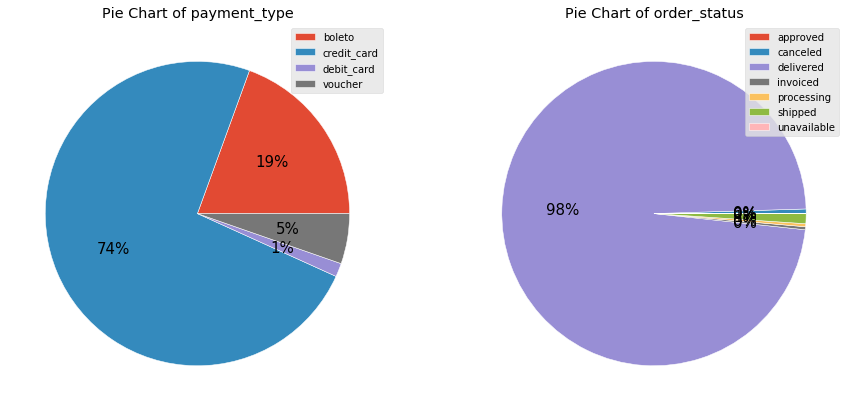

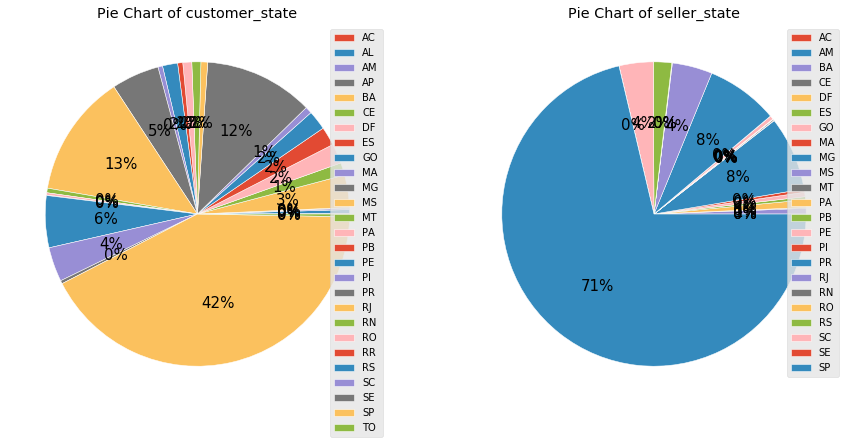

In [18]:
# grouped dataframe by a categorical feature:
df_grp_pymt_type = eda_grouped_df_var(df_eda, 'payment_type')
df_grp_order_status = eda_grouped_df_var(df_eda, 'order_status')
df_grp_customer_state = eda_grouped_df_var(df_eda, 'customer_state')
df_grp_seller_state = eda_grouped_df_var(df_eda, 'seller_state')

# Plot pie chart(s) by categorical features:
plot_pie_chart(df_grp_pymt_type, 'payment_type',
              df_grp_order_status, 'order_status')

plot_pie_chart(df_grp_customer_state, 'customer_state',
              df_grp_seller_state, 'seller_state')

### Summary: Pie Chart ###
* Payment Method: 74 % of customers made purchases by a credit card.
* Order Status: 98% of purchases are delivered to customers.
* Customer State: about 42% of customers' reside in Sao Paolo follow by other states.
* Seller State: about 72% of sellers' reside in Sao Paolo followed by other states.

### Bi-variate: Box-Whisker Plots ###

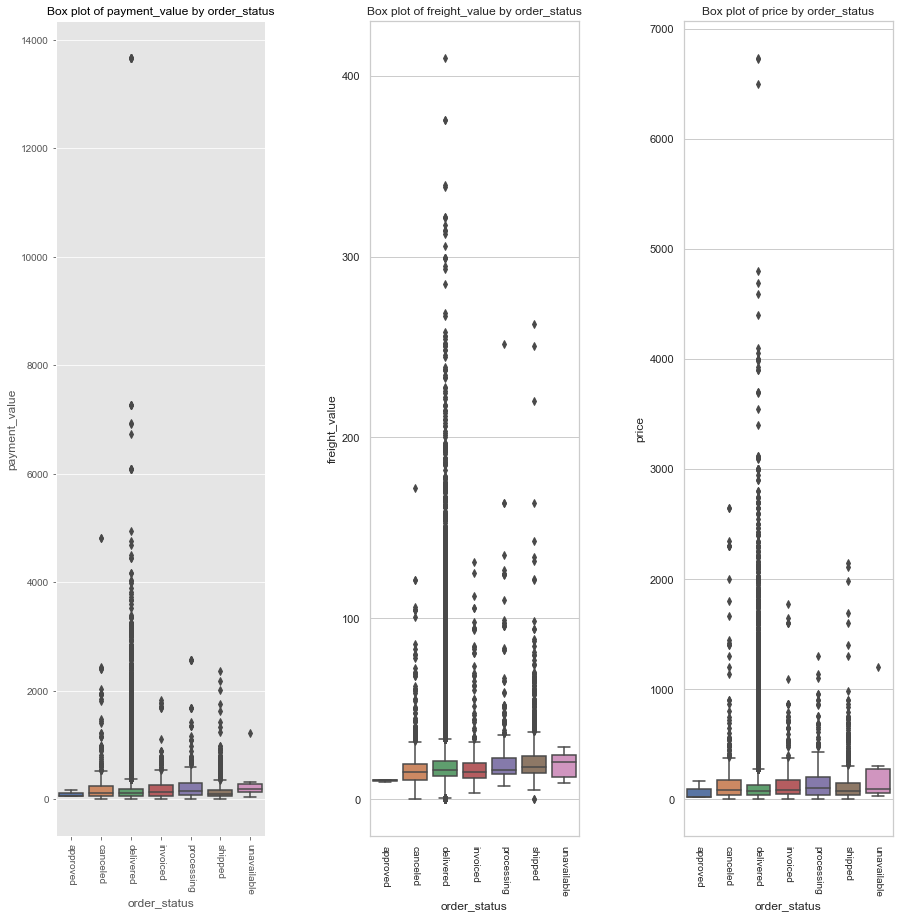

In [19]:
# ---7 visualize data: bi-variate ---
# plot a box-whisker:    
plot_box(df_eda, 'payment_value', 'order_status',
        'freight_value', 'order_status',
        'price', 'order_status')

### Summary: Box-Whisker Plot ###
* Payment: when order status is unavaiable, mean payment is the highest. Also, a lot of variance in mean payment is noted when order status is delivered.
* Freight: when order status is unavaiable, mean freight is the highest. Also, a lot of variance in mean freight is noted when order status is delivered.
* Price: when order status is unavaiable, mean price is the highest. Also, a lot of variance in mean price is noted when order status is delivered.

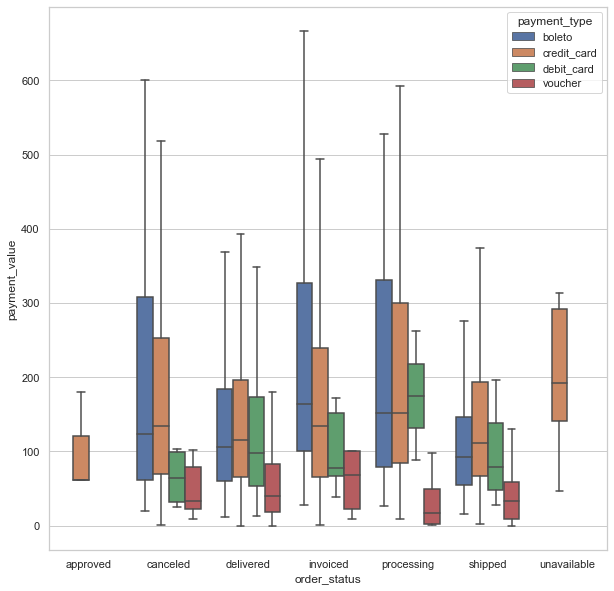

In [20]:
# add 'Country' as a third variable 
plt.figure(figsize=(10,10))
sns.boxplot(x='order_status', y='payment_value',
            data=df_eda, sym= '', hue='payment_type')

### Summary: Box-Whisker Plot by payment Type ###
Mean payment is the highest when order status is still in processing and paid by "debit card". On contrary, mean payment is the lowest when order status is processing and paid by voucher.

### Bi-variate: Correlation Matrix Plot ###

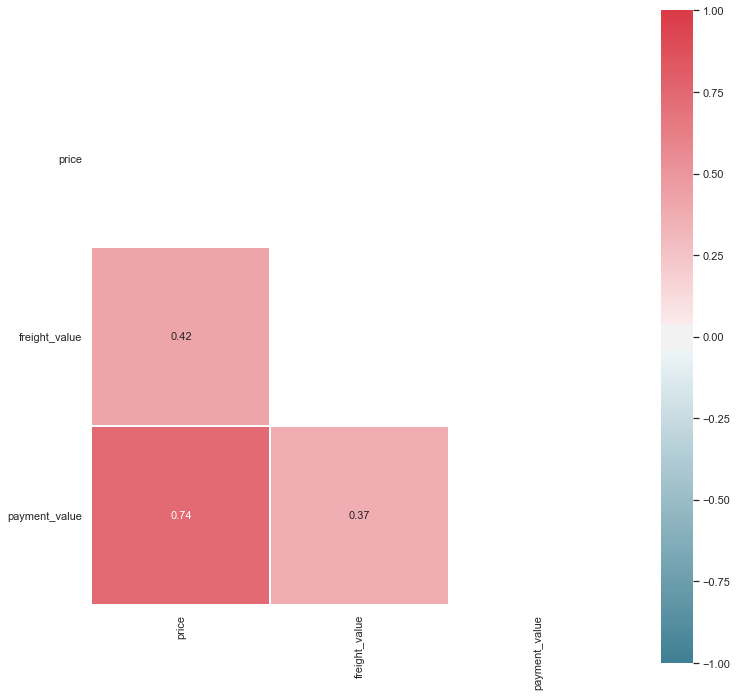

In [21]:
# create a dataframe:
df_eda_cm = df_eda.copy()

# plot a correlation matrix:
plot_corr_matrix(df_eda_cm, vars_num)

### Summary: Correlation Matrix Plot ###
1. Payment shows positive strong correlation with price (r=0.74)
2. Payment shows postive moderate correlation with freight (r=0.37).

### Bi-variate: Cross Tabulation ###

In [22]:
# plot a cross-tabulation:
plot_crosstab(df_eda, 'order_status', 'customer_state')

customer_state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
order_status,,,,,,,,,,,,,,,,,,,,,
approved,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
canceled,0,0,0,0,15,4,9,8,11,4,...,23,73,0,1,1,24,15,0,305,1
delivered,94,441,169,83,3930,1499,2421,2307,2372,818,...,5868,14873,561,281,46,6383,4222,386,48525,334
invoiced,0,2,0,0,9,1,3,4,5,2,...,17,28,0,1,0,25,16,1,197,0
processing,0,6,0,1,16,6,8,2,7,0,...,17,34,1,3,0,14,16,0,186,1
shipped,1,9,2,0,78,41,32,17,35,20,...,37,318,7,0,5,39,33,10,352,3
unavailable,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,3,0


In [23]:
# plot a cross-tabulation:
plot_crosstab(df_eda, 'order_status', 'seller_state')

seller_state,AC,AM,BA,CE,DF,ES,GO,MA,MG,MS,...,PE,PI,PR,RJ,RN,RO,RS,SC,SE,SP
order_status,,,,,,,,,,,,,,,,,,,,,
approved,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,1
canceled,0,0,2,0,3,0,4,0,57,0,...,1,0,34,24,0,0,6,25,0,410
delivered,0,3,679,99,930,382,536,406,9026,60,...,462,11,8798,4877,56,14,2251,4180,10,82061
invoiced,0,0,7,0,5,0,0,0,29,0,...,0,0,40,17,0,0,4,9,0,260
processing,1,0,5,0,1,2,2,0,29,0,...,0,0,37,47,0,0,13,10,0,228
shipped,0,0,5,3,8,5,7,3,117,0,...,2,1,108,50,0,0,9,32,0,892
unavailable,0,0,0,1,0,1,0,0,0,0,...,0,0,0,2,0,0,0,1,0,2


### Summary: Cross Tabulation ###
1. order status and customer state: Majority of customers are from Sao Paolo and orders delivered to them.
1. order status and seller state: Majority of sellers are from Sao Paolo and orders sent by them.

### Linear Regression Analyses ###

In [24]:
#---- Plot a linear regression plot: w numerical variables ----#
# Compute Pearson r for combination of X and Y:
r_freight_payment = compute_pearson_r(df_eda, 'freight_value', 'payment_value')
r_price_payment = compute_pearson_r(df_eda, 'price', 'payment_value')

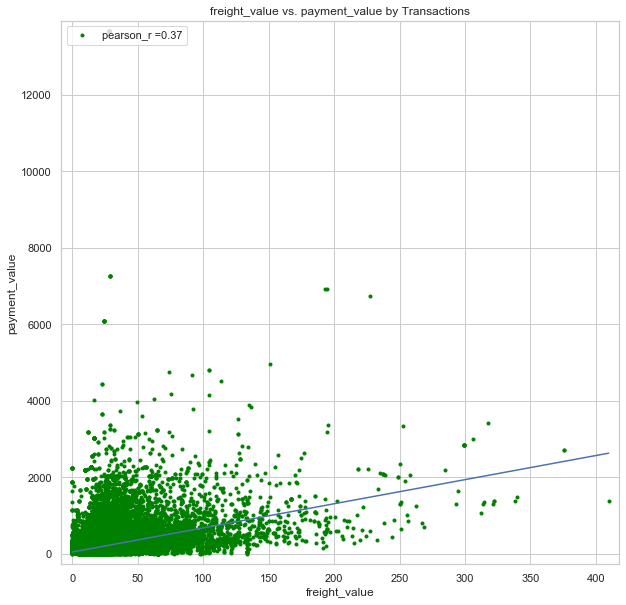

In [25]:
# Plot a linear regression analysis:
plot_linear_reg(df_eda, 'freight_value', 'payment_value',
                r_freight_payment, 'green', 'Transactions')
plt.show()

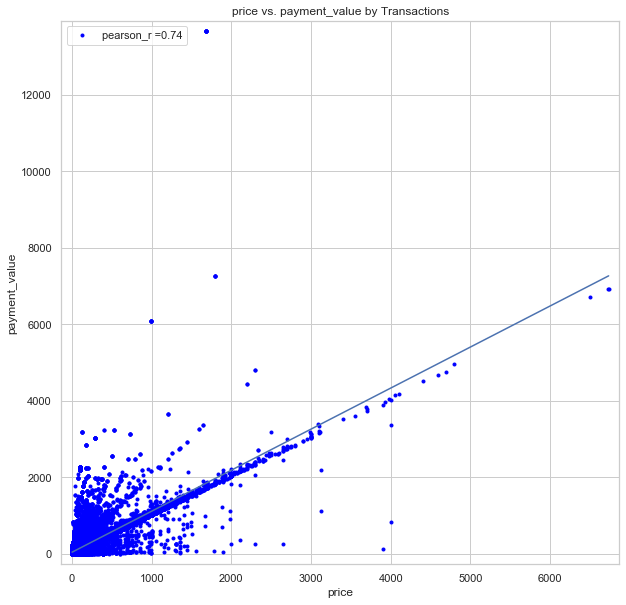

In [26]:
# Plot a linear regression analysis:
plot_linear_reg(df_eda, 'price', 'payment_value',
                r_price_payment, 'blue', 'Transactions')
plt.show()

### Summary: Linear Regression ###
* Plot 1: shows the positive moderate correlation between freight and payment with the **Pearson's coefficient (r=0.37)**.
* Plot 2: shows the positive strong correlation between freight and payment with the **Pearson's coefficient(r=0.74)**.